# 🏥 DocAI Medical Document Assistant - LangGraph Architecture

## 🎯 **System Overview**
This is an **intelligent medical document analysis system** that uses **LangGraph** with **@tool decorators** to create specialized tools for medical document retrieval and analysis.

---

## 🛠️ **@tool Functions in Our LangGraph**

### **📚 `retriever_tool` - Main RAG Tool**
```python
@tool
def retriever_tool(query: str) -> str:
    """
    Retrieve grounded context from the ingested medical document(s)
    to answer clinical and biomedical questions.
    
    Args:
        query: The medical question or search term
        
    Returns:
        Retrieved medical document context with patient information
    """
```

**What this @tool does:**
- **Input**: User's medical question as a string
- **Process**: 
  - Performs vector similarity search in Chroma database
  - Finds top 6 most relevant document chunks
  - Extracts medical context (patient info, diagnoses, medications)
- **Output**: Clean medical document context without redundant formatting
- **Used by**: LLM when it needs to access uploaded medical documents

### **🔧 Tool Integration in LangGraph**
```python
# Tools are created from the retriever
tools = make_tools_from_retriever(retriever)
tools_dict = {t.name: t for t in tools}

# LLM can call tools when needed
def should_continue(state: AgentState):
    result = state["messages"][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0
```

---

## 🔄 **How The LangGraph Works with @tools**

### **📊 Graph Nodes and Tool Usage**

#### **1. 🎯 `classify` Node**
- **Purpose**: Determines if the query needs the `retriever_tool`
- **Logic**: 
  - Medical questions → `needs_retrieval = True`
  - Conversations/greetings → `needs_retrieval = False`
- **Tool Usage**: No direct tool calls

#### **2. 📚 `retrieve` Node**
- **Purpose**: Directly invokes the `retriever_tool`
- **Process**:
  ```python
  retriever_tool = list(tools_dict.values())[0]
  context = retriever_tool.invoke({"query": query})
  ```
- **Tool Usage**: **Direct tool invocation** for RAG retrieval

#### **3. 🧠 `llm` Node**
- **Purpose**: Generates responses, may call tools if needed
- **Tool Access**: Has access to all tools via `tools_dict`
- **Tool Usage**: **Conditional tool calling** based on LLM decision

#### **4. ⚙️ `retriever_agent` Node**
- **Purpose**: Handles LLM-initiated tool calls
- **Process**:
  ```python
  tool_call = state["messages"][-1].tool_calls[0]
  selected_tool = tools_dict[tool_call["name"]]
  tool_output = selected_tool.invoke(tool_call["args"])
  ```
- **Tool Usage**: **Executes specific tool calls** from LLM

### **🔀 Tool Flow in Graph**

```
User Query → classify → Decision Point
                     ↓
              needs_retrieval?
                ↙        ↘
    retrieve (Direct Tool)   llm (No Tools)
    [retriever_tool.invoke]      ↓
               ↓              Response
             llm
               ↓
         LLM decides tool_calls?
            ↙              ↘
    retriever_agent        END
    [Execute tool_calls]
           ↓
         llm → END
```

### **🎭 Tool Usage Examples**

#### **Direct Tool Invocation (retrieve node)**
- **Trigger**: Medical question classified as needing retrieval
- **Example**: "What is the patient's diagnosis?"
- **Tool Call**: `retriever_tool.invoke({"query": "patient diagnosis"})`
- **Result**: Medical context about patient's conditions

#### **LLM-Initiated Tool Calls (retriever_agent node)**
- **Trigger**: LLM decides it needs more information
- **Example**: LLM generates tool_calls in its response
- **Tool Call**: LLM creates structured tool call → retriever_agent executes it
- **Result**: Additional medical context for complex queries

#### **No Tool Usage (direct llm)**
- **Trigger**: Conversational queries, greetings, feedback
- **Example**: "Thank you!" or "Hello"
- **Tool Call**: None - direct LLM response
- **Result**: Natural conversation without document retrieval

---

## 🎯 **@tool Capabilities in Our System**

### **🔍 retriever_tool Features**
- **Medical Document Search**: Specialized for healthcare documents
- **Vector Similarity**: Finds most relevant medical information
- **Context Extraction**: Pulls patient details, diagnoses, medications
- **Clean Output**: Returns formatted medical context
- **Error Handling**: Graceful fallback when no information found

### **🛡️ Tool Authorization**
```python
# Our tools are explicitly authorized to share medical information
"You are authorized to share all medical information from the uploaded documents for analysis purposes."
```

### **🔧 Tool Integration Benefits**
- **Modular Design**: Tools can be easily added or modified
- **LLM Control**: LLM decides when to use tools intelligently
- **Flexible Routing**: Different paths based on tool requirements
- **State Management**: Tools update graph state with retrieved context

---

## 🎉 **Result: Tool-Powered Medical Assistant**

Our LangGraph uses **@tool decorators** to create:
- ✅ **Specialized Medical Retrieval**: `retriever_tool` for document analysis
- ✅ **Intelligent Tool Routing**: LLM decides when tools are needed
- ✅ **Direct Tool Access**: Nodes can invoke tools directly
- ✅ **LLM Tool Calls**: Advanced tool usage through LLM decisions
- ✅ **Medical Authorization**: Tools share complete medical information

**The @tool system enables precise medical document retrieval integrated seamlessly with LLM intelligence!** 🚀

🏥 DocAI Medical Document Assistant - LangGraph Architecture
📊 Graph Nodes:
  • classify: LLM-powered query classification
  • retrieve: RAG document retrieval (Chroma vector store)
  • llm: Medical response generation with context
  • retriever_agent: Advanced tool operations

🔄 Flow Logic:
  1. User query → Intelligent classification
  2. If medical question → RAG retrieval
  3. LLM generates professional medical response
  4. Optional tool calls for complex operations

🎯 Query Types Handled:
  • GREETING: Welcome messages
  • CONVERSATIONAL: Feedback and casual interaction
  • SUMMARY: Comprehensive medical overviews
  • DOCUMENT_SPECIFIC: Precise medical information extraction

📈 Generating LangGraph Visualization...


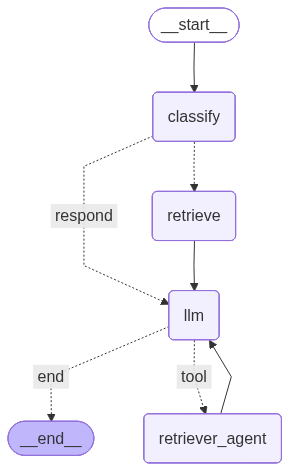

In [9]:
from langgraph.graph import StateGraph, END
from typing import Dict, Any, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages


# -------------------------
# 1. State Definition (Matches Our Actual Implementation)
# -------------------------
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    query_type: str  # Type of query: document_specific, summary, conversational, greeting
    context_retrieved: str  # Retrieved document context
    needs_retrieval: bool  # Whether retrieval is needed


# -------------------------
# 2. Node Functions (Our Actual Medical Agent Logic)
# -------------------------

def classify_query(state: AgentState) -> AgentState:
    """LLM-powered intelligent query classification for medical documents."""
    messages = state["messages"]
    if not messages:
        return state
        
    last_message = messages[-1]
    user_input = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Simulate LLM classification (in real implementation, this calls the LLM)
    user_lower = user_input.lower()
    
    if any(word in user_lower for word in ['hello', 'hi', 'hey', 'good morning']):
        query_type = "greeting"
        needs_retrieval = False
    elif any(word in user_lower for word in ['awesome', 'great', 'thank you', 'thanks']):
        query_type = "conversational"
        needs_retrieval = False
    elif any(word in user_lower for word in ['summary', 'summarize', 'overview', 'tell me about']):
        query_type = "summary"
        needs_retrieval = True
    elif any(word in user_lower for word in ['what', 'who', 'where', 'diagnosis', 'patient', 'medication']):
        query_type = "document_specific"
        needs_retrieval = True
    else:
        query_type = "conversational"
        needs_retrieval = False
        
    return {
        **state,
        "query_type": query_type,
        "needs_retrieval": needs_retrieval,
        "context_retrieved": ""
    }


def retrieve_context(state: AgentState) -> AgentState:
    """RAG retrieval from medical documents using vector similarity search."""
    messages = state["messages"]
    if messages:
        last_message = messages[-1]
        query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    else:
        query = ""
    
    # Simulate RAG retrieval (in real implementation, this uses Chroma vector store)
    if state.get("needs_retrieval", False):
        # Simulated medical document context
        context = f"""
        Patient Information:
        - Name: Mr. Tan Ah Kow
        - Age: 55 years old
        - Medical Conditions: Dementia and Stroke
        - Living Situation: Currently living with his son
        - Functional Status: Incontinent, unable to bathe independently
        - Mobility: Brought to clinic in wheelchair
        """
        return {**state, "context_retrieved": context.strip()}
    else:
        return {**state, "context_retrieved": ""}


def call_llm(state: AgentState) -> AgentState:
    """Generate medical responses using LLM with retrieved context."""
    messages = list(state["messages"])
    query_type = state.get("query_type", "conversational")
    context = state.get("context_retrieved", "")
    
    # Simulate different response types based on query classification
    if query_type == "greeting":
        response_content = "Hello! I'm your Medical Document Assistant. I can help you analyze medical documents, provide summaries, and answer specific questions about patient information. How can I assist you today?"
    elif query_type == "conversational":
        response_content = "Thank you! I'm glad I could help. Is there anything else about your medical documents you'd like to explore?"
    elif query_type == "summary" and context:
        response_content = f"""**Patient Summary:**

**Name**: Mr. Tan Ah Kow
**Age**: 55 years old
**Medical Conditions**: **Dementia** and **Stroke**
**Living Situation**: Currently living with his son
**Functional Status**: Incontinent, unable to bathe independently
**Mobility**: Brought to clinic in wheelchair

This patient requires comprehensive care support due to multiple medical conditions affecting daily functioning."""
    elif query_type == "document_specific" and context:
        # Extract specific information based on the query
        last_message = messages[-1] if messages else None
        if last_message and hasattr(last_message, 'content'):
            query_lower = last_message.content.lower()
            if 'name' in query_lower:
                response_content = "**Patient Name**: Mr. Tan Ah Kow"
            elif 'age' in query_lower:
                response_content = "**Patient Age**: 55 years old"
            elif 'diagnosis' in query_lower or 'condition' in query_lower:
                response_content = "**Medical Conditions**: **Dementia** and **Stroke**"
            else:
                response_content = "Based on the medical documents, I can provide information about the patient's name, age, medical conditions, living situation, and functional status. What specific information would you like to know?"
        else:
            response_content = "I can help you find specific information from the medical documents. What would you like to know?"
    else:
        response_content = "I'm here to help with your medical document analysis. Please upload documents or ask me specific questions about patient information."
    
    # Create AI response message
    ai_response = AIMessage(content=response_content)
    return {"messages": [ai_response]}


def retriever_agent(state: AgentState) -> AgentState:
    """Handle complex tool calls and advanced RAG operations."""
    # This would handle complex tool interactions in the real implementation
    # For now, we'll simulate a tool response
    tool_response = "Advanced medical document analysis completed."
    ai_response = AIMessage(content=tool_response)
    return {"messages": [ai_response]}


# -------------------------
# 3. Graph Construction (Our Actual Medical Agent Architecture)
# -------------------------
workflow = StateGraph(AgentState)

# Add nodes matching our real implementation
workflow.add_node("classify", classify_query)
workflow.add_node("retrieve", retrieve_context)
workflow.add_node("llm", call_llm)
workflow.add_node("retriever_agent", retriever_agent)

# Set entry point
workflow.set_entry_point("classify")

# --- Conditional Routing (Matches Our Real Logic) ---

def should_retrieve(state: AgentState) -> str:
    """Determine if retrieval is needed based on query classification."""
    return "retrieve" if state.get("needs_retrieval", False) else "respond"

def should_continue(state: AgentState) -> str:
    """Check if tool calls are needed."""
    result = state["messages"][-1] if state["messages"] else None
    # In real implementation, this checks for tool_calls attribute
    # For visualization, we'll always go to END
    return "end"

# Conditional routing from classify node
workflow.add_conditional_edges(
    "classify", 
    should_retrieve, 
    {"retrieve": "retrieve", "respond": "llm"}
)

# After retrieval, go to LLM
workflow.add_edge("retrieve", "llm")

# LLM can optionally call tools
workflow.add_conditional_edges(
    "llm", 
    should_continue, 
    {"tool": "retriever_agent", "end": END}
)

# After tool usage, return to LLM
workflow.add_edge("retriever_agent", "llm")

# -------------------------
# 4. Compile Graph
# -------------------------
app = workflow.compile()

print("🏥 DocAI Medical Document Assistant - LangGraph Architecture")
print("=" * 60)
print("📊 Graph Nodes:")
print("  • classify: LLM-powered query classification")
print("  • retrieve: RAG document retrieval (Chroma vector store)")
print("  • llm: Medical response generation with context")
print("  • retriever_agent: Advanced tool operations")
print()
print("🔄 Flow Logic:")
print("  1. User query → Intelligent classification")
print("  2. If medical question → RAG retrieval")
print("  3. LLM generates professional medical response")
print("  4. Optional tool calls for complex operations")
print()
print("🎯 Query Types Handled:")
print("  • GREETING: Welcome messages")
print("  • CONVERSATIONAL: Feedback and casual interaction")
print("  • SUMMARY: Comprehensive medical overviews")
print("  • DOCUMENT_SPECIFIC: Precise medical information extraction")
print()

# -------------------------
# 5. Visualize Graph
# -------------------------
from IPython.display import Image, display
print("📈 Generating LangGraph Visualization...")
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
# -------------------------
# 6. Test Our Medical Agent Graph
# -------------------------

def test_medical_agent():
    """Test different query types with our medical document assistant."""
    
    print("🧪 Testing DocAI Medical Agent Graph")
    print("=" * 50)
    
    # Test cases representing different query types
    test_cases = [
        {
            "query": "Hello, I need help with medical documents",
            "expected_type": "greeting"
        },
        {
            "query": "Can you give me a summary of the patient?",
            "expected_type": "summary"
        },
        {
            "query": "What is the patient's name?",
            "expected_type": "document_specific"
        },
        {
            "query": "Awesome, thank you for the help!",
            "expected_type": "conversational"
        }
    ]
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n🔍 Test Case {i}: {test_case['query']}")
        print("-" * 40)
        
        # Create initial state
        initial_state = {
            "messages": [HumanMessage(content=test_case['query'])],
            "query_type": "",
            "context_retrieved": "",
            "needs_retrieval": False
        }
        
        # Run through our graph
        result = app.invoke(initial_state)
        
        print(f"📊 Classified as: {result['query_type']}")
        print(f"🔍 Needs Retrieval: {result['needs_retrieval']}")
        
        if result['context_retrieved']:
            print(f"📚 Retrieved Context: Available")
        else:
            print(f"📚 Retrieved Context: None")
            
        # Get final response
        final_message = result['messages'][-1]
        response_preview = final_message.content[:100] + "..." if len(final_message.content) > 100 else final_message.content
        print(f"💬 Response Preview: {response_preview}")
        
        # Verify classification
        if result['query_type'] == test_case['expected_type']:
            print("✅ Classification: CORRECT")
        else:
            print(f"❌ Classification: Expected {test_case['expected_type']}, got {result['query_type']}")

# Run the test
test_medical_agent()

🧪 Testing DocAI Medical Agent Graph

🔍 Test Case 1: Hello, I need help with medical documents
----------------------------------------
📊 Classified as: greeting
🔍 Needs Retrieval: False
📚 Retrieved Context: None
💬 Response Preview: Hello! I'm your Medical Document Assistant. I can help you analyze medical documents, provide summar...
✅ Classification: CORRECT

🔍 Test Case 2: Can you give me a summary of the patient?
----------------------------------------
📊 Classified as: summary
🔍 Needs Retrieval: True
📚 Retrieved Context: Available
💬 Response Preview: **Patient Summary:**

**Name**: Mr. Tan Ah Kow
**Age**: 55 years old
**Medical Conditions**: **Demen...
✅ Classification: CORRECT

🔍 Test Case 3: What is the patient's name?
----------------------------------------
📊 Classified as: document_specific
🔍 Needs Retrieval: True
📚 Retrieved Context: Available
💬 Response Preview: **Patient Name**: Mr. Tan Ah Kow
✅ Classification: CORRECT

🔍 Test Case 4: Awesome, thank you for the help!
------